In [1]:
# Import all necessary libraries
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



In [3]:
# Download the data
# ^GSPC,^IXIC, ITA, VTI, RCD"
stock_data = yf.download(tickers="^GSPC", start='1980-01-01', end='2023-01-01')
stock_data.head()
# stock_ixic = yf.download(tickers = "^IXIC", start='2000-01-01', end='2010-01-01')
# stock_ita = yf.download(tickers = "ITA", start='2000-01-01', end='2010-01-01')
# stock_vti= yf.download(tickers = "VTI", start='2000-01-01', end='2010-01-01')
# stock_rcd = yf.download(tickers = "RCD", start='2000-01-01', end='2010-01-01')


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-01-02,0.0,108.430000,105.290001,105.760002,105.760002,40610000
1980-01-03,0.0,106.080002,103.260002,105.220001,105.220001,50480000
1980-01-04,0.0,107.080002,105.089996,106.519997,106.519997,39130000
1980-01-07,0.0,107.800003,105.800003,106.809998,106.809998,44500000
1980-01-08,0.0,109.290001,106.290001,108.949997,108.949997,53390000


In [4]:
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-01-02,0.0,108.430000,105.290001,105.760002,105.760002,40610000
1980-01-03,0.0,106.080002,103.260002,105.220001,105.220001,50480000
1980-01-04,0.0,107.080002,105.089996,106.519997,106.519997,39130000
1980-01-07,0.0,107.800003,105.800003,106.809998,106.809998,44500000
1980-01-08,0.0,109.290001,106.290001,108.949997,108.949997,53390000


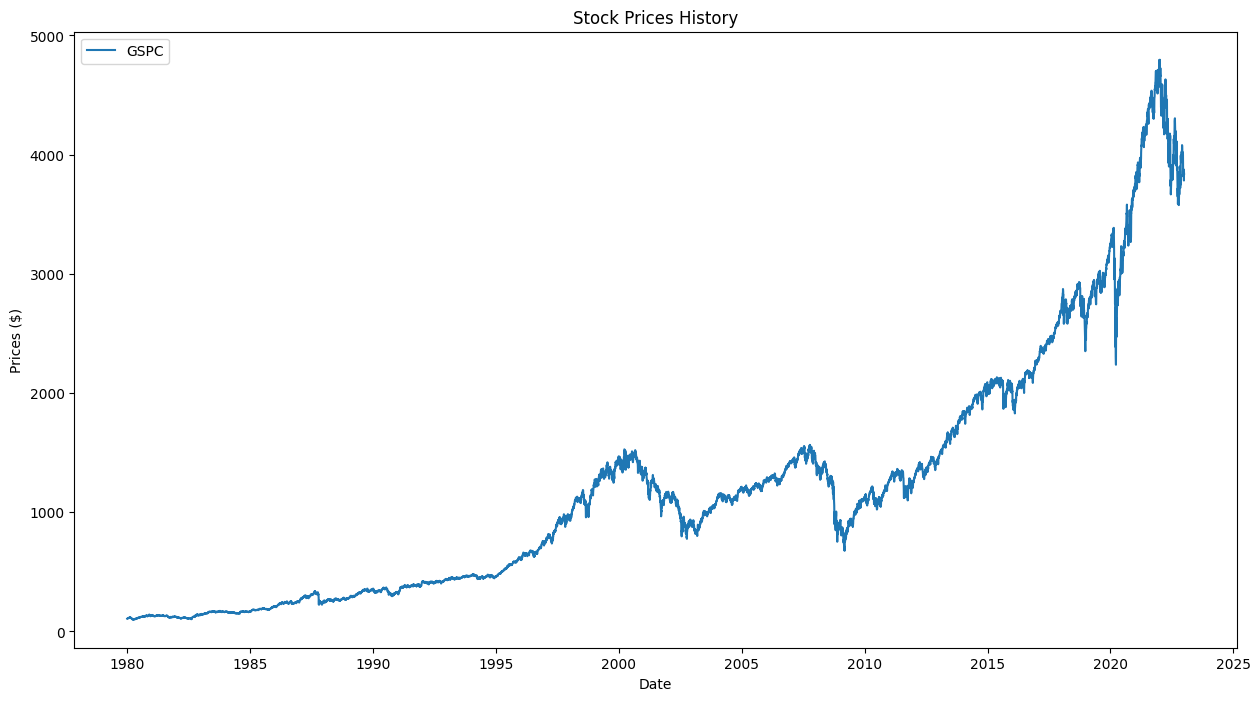

In [5]:
# Plot the data
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')
plt.legend(['GSPC', 'IXIC'])

In [6]:
# Prepare train set
close_prices = stock_data['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [7]:
# Prepare test set
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])


# n_input = x_train.shape[1] * x_train.shape[2]
# trainX = x_train.reshape((x_train.shape[0], n_input))
# n_input = x_test.shape[1] * x_test.shape[2]
# x_test = x_test.reshape((x_test.shape[0], n_input))
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [8]:
# Set up LSTM
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the model

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
4081/8615 [=============>................] - ETA: 4:11 - loss: 1.3530e-04

In [ ]:
# Make Predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

C:\Users\amsha\AppData\Local\Temp\ipykernel_56880\3669295464.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


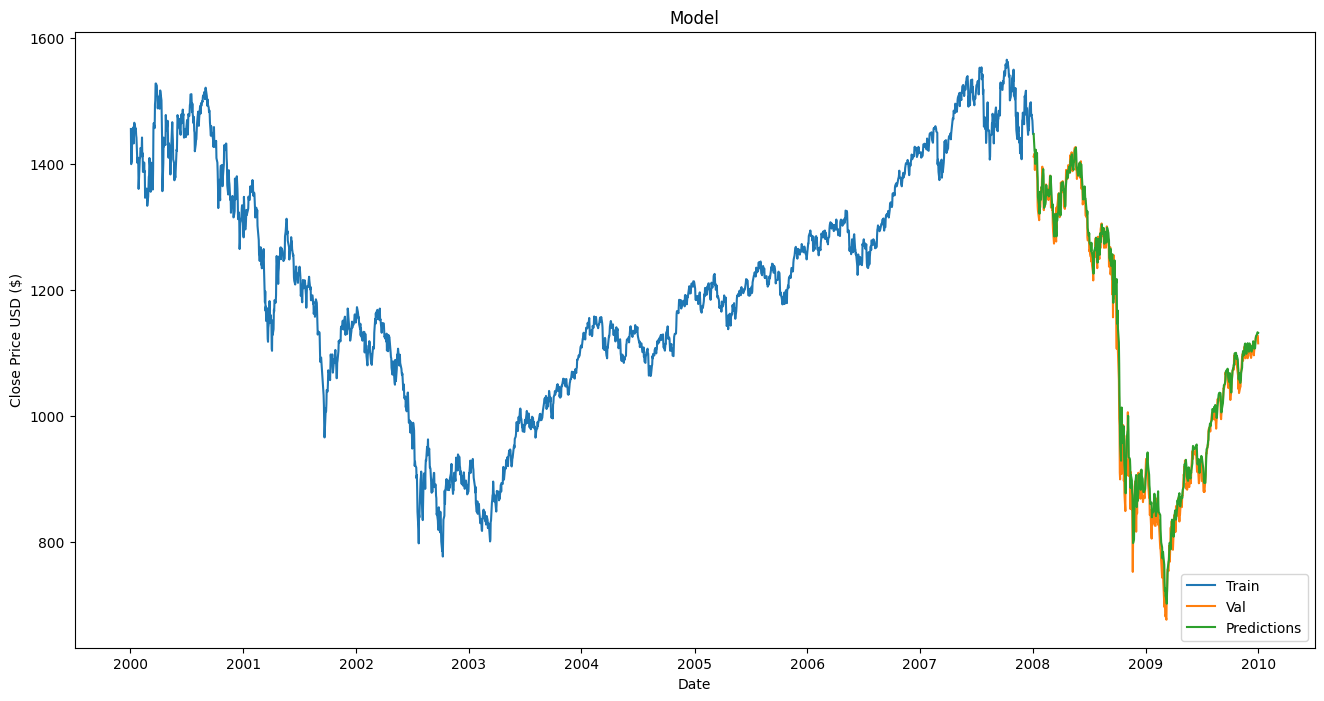

In [11]:
# Visualize the predicted prices
data = stock_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()